In [1]:
from pathlib import Path
import yaml
import numpy as np
from torch.utils.data import DataLoader

from torchvision.models import resnet18
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import random_split, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.metrics import roc_curve, auc, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from omegaconf import OmegaConf
from hydra.utils import instantiate

import os
import torch
import sys
import pickle

sys.path.append("/home/erogullari/Workspace/cav-disentanglement")
out_dir = Path("/home/erogullari/Workspace/cav-disentanglement/media/implicit_disentanglement")
out_dir.mkdir(parents=True, exist_ok=True)

In [2]:
from utils.cav import compute_cavs

def get_baseline_cavs(model_name:str, layer:str, dataset_name:str, cav_type:str) -> torch.Tensor:
    base_path = Path("/home/erogullari/Workspace/cav-disentanglement/variables")
    vars_path = base_path / dataset_name / f"{model_name}" / f"{layer}.pth"
    vars = torch.load(vars_path, map_location="cpu", weights_only=True)
    encs = vars['encs']
    labels = vars['labels']
    cavs, _ = compute_cavs(encs, labels, type=cav_type, normalize=True)
    return cavs

In [3]:
celeba_vars = torch.load("/home/erogullari/Workspace/cav-disentanglement/variables/celeba/vgg16/features.28.pth", map_location="cpu", weights_only=True)
elements_vars = torch.load("/home/erogullari/Workspace/cav-disentanglement/variables/elements/simplenet/features.18.pth", map_location="cpu", weights_only=True)

## Cosine Sim Matrix

In [7]:
pattern_cavs = get_baseline_cavs("vgg16", "features.28", "celeba", "pattern_cav")
multi_cavs = get_baseline_cavs("vgg16", "features.28", "celeba", "multi_cav")

torch.linalg.norm(pattern_cavs, dim=1), torch.linalg.norm(multi_cavs, dim=1)

(tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000]))

In [8]:
from utils.visualizations import visualize_before_after_sim_matrices

cos_sim_pattern = pattern_cavs @ pattern_cavs.T
cos_sim_multi = multi_cavs @ multi_cavs.T
cnames = [str(i) for i in range(40)]

fig = visualize_before_after_sim_matrices(cos_sim_pattern, cos_sim_multi, labels=cnames)
fig.savefig(out_dir / "celeba_cav_sim_matrices.pdf", dpi=300, bbox_inches='tight', format='pdf')

In [4]:
pattern_cavs = get_baseline_cavs("simplenet", "features.18", "elements", "pattern_cav")
multi_cavs = get_baseline_cavs("simplenet", "features.18", "elements", "multi_cav")

torch.linalg.norm(pattern_cavs, dim=1), torch.linalg.norm(multi_cavs, dim=1)

(tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000]))

In [5]:
cnames = [
    "shape:circle",
    "shape:cross",
    "shape:plus",
    "shape:square",
    "shape:triangle",
    "color:blue",
    "color:cyan",
    "color:green",
    "color:magenta",
    "color:red",
    "color:yellow",
    "texture:solid",
    "texture:spots_chequerboard",
    "texture:spots_polka",
    "texture:spots_random",
    "texture:spots_regular",
    "texture:stripes_diagonal",
    "texture:stripes_diagonal_alt",
    "texture:stripes_horizontal",
    "texture:stripes_vertical"
]

In [6]:
from utils.visualizations import visualize_before_after_sim_matrices

cos_sim_pattern = pattern_cavs @ pattern_cavs.T
cos_sim_multi = multi_cavs @ multi_cavs.T
# cnames = [str(i) for i in range(20)]

fig = visualize_before_after_sim_matrices(cos_sim_pattern, cos_sim_multi, labels=cnames)
fig.savefig(out_dir / "elements_cav_sim_matrices.pdf", dpi=300, bbox_inches='tight', format='pdf')

In [7]:
# Average orthogonality of enforced concepts in Elements dataset
concept_pair_ids = [(4, 18), (0, 19), (3, 14), (2, 9), (1, 5)]

avg_orth_pattern = 0
for i, j in concept_pair_ids:
    avg_orth_pattern += (1 - cos_sim_pattern[i, j].abs().item())
avg_orth_pattern /= len(concept_pair_ids)

avg_orth_multi = 0
for i, j in concept_pair_ids:
    avg_orth_multi += (1 - cos_sim_multi[i, j].abs().item())
avg_orth_multi /= len(concept_pair_ids)

print(f"Average orthogonality for pattern CAVs: {avg_orth_pattern:.4f}")
print(f"Average orthogonality for multi CAVs: {avg_orth_multi:.4f}")

Average orthogonality for pattern CAVs: 0.5548
Average orthogonality for multi CAVs: 0.8893


## Per-Concept - CelebA (VGG16) and Elements (SimpleNet)

Avg AUC CelebA: Pattern 0.7762, Multi 0.7172
Avg Orth CelebA: Pattern 0.4403, Multi 0.7590


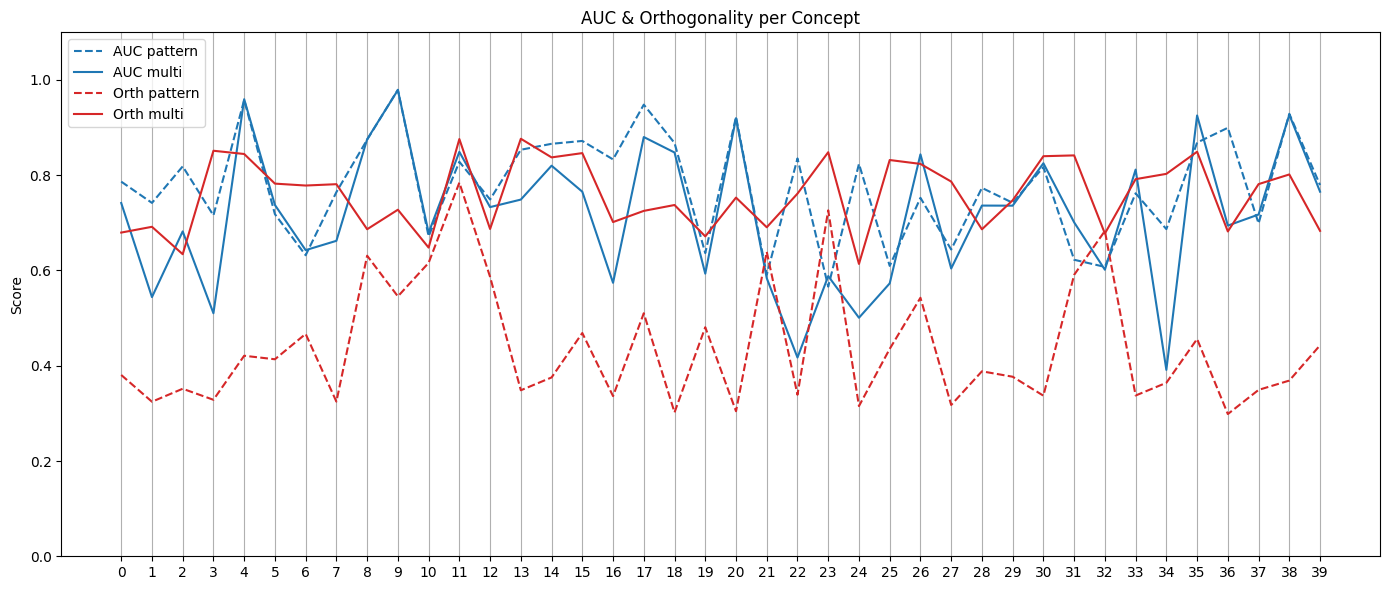

In [ ]:
from utils.metrics import compute_auc_performance, get_uniqueness

def plot_pattern_multi_auc_orthogonality(
    dataset_name: str,
    model_name: str,
    layer: str,
    *,
    variables_root: Path | str = Path("/home/erogullari/Workspace/cav-disentanglement/variables"),
    concept_names: list[str] | None = None,
    sort_by: str = "none",  # "auc_delta", "orth_delta", "name", or "none"
    out_path: Path | str | None = None,
):
    vars_path = Path(variables_root) / dataset_name / model_name / f"{layer}.pth"
    vars = torch.load(vars_path, map_location="cpu", weights_only=True)
    encs = vars["encs"]
    labels = vars["labels"].clamp(min=0)

    concept_names = [f"{i}" for i in range(labels.shape[1])]

    cavs_pattern, _ = compute_cavs(encs, labels, type="pattern_cav", normalize=True)
    cavs_multi, _ = compute_cavs(encs, labels, type="multi_cav", normalize=True)

    auc_pattern = compute_auc_performance(cavs_pattern, encs, labels)
    auc_multi = compute_auc_performance(cavs_multi, encs, labels)
    orth_pattern = get_uniqueness(cavs_pattern)
    orth_multi = get_uniqueness(cavs_multi)

    if sort_by == "auc_delta":
        order = np.argsort(np.array(auc_multi) - np.array(auc_pattern))
    elif sort_by == "orth_delta":
        order = np.argsort(np.array(orth_multi) - np.array(orth_pattern))
    elif sort_by == "name":
        order = np.argsort(np.array(concept_names))
    elif sort_by == "none":
        order = np.arange(len(concept_names))
    else:
        raise ValueError("sort_by must be one of: auc_delta, orth_delta, name, none")

    concept_names = [concept_names[i] for i in order]
    auc_pattern = np.array(auc_pattern)[order]
    auc_multi = np.array(auc_multi)[order]
    orth_pattern = np.array(orth_pattern)[order]
    orth_multi = np.array(orth_multi)[order]

    x = np.arange(len(concept_names))
    fig, ax = plt.subplots(figsize=(max(10, 0.35 * len(concept_names)), 6))
    ax.plot(x, auc_pattern, color="tab:blue", linestyle="--", label="AUC pattern")
    ax.plot(x, auc_multi, color="tab:blue", linestyle="-", label="AUC multi")
    ax.plot(x, orth_pattern, color="tab:red", linestyle="--", label="Orth pattern")
    ax.plot(x, orth_multi, color="tab:red", linestyle="-", label="Orth multi")

    ax.set_xticks(x)
    ax.set_xticklabels(concept_names)
    ax.set_ylabel("Score")
    ax.set_ylim(0, 1.1)
    ax.grid(axis="x")
    ax.set_title("AUC & Orthogonality per Concept")
    ax.legend()
    fig.tight_layout()

    if out_path is not None:
        out_path = Path(out_path)
        if out_path.suffix:
            save_path = out_path
        else:
            out_path.mkdir(parents=True, exist_ok=True)
            save_path = out_path / "auc_orth_pattern_vs_multi.png"
        fig.savefig(save_path, bbox_inches="tight")
        plt.close(fig)

    return {
        "auc_pattern": auc_pattern,
        "auc_multi": auc_multi,
        "orth_pattern": orth_pattern,
        "orth_multi": orth_multi,
        "concept_names": concept_names,
    }

# Example:
results = plot_pattern_multi_auc_orthogonality("celeba", "vgg16", "features.28", out_path=None)
print(f"Avg AUC CelebA: Pattern {np.mean(results['auc_pattern']):.4f}, Multi {np.mean(results['auc_multi']):.4f}")
print(f"Avg Orth CelebA: Pattern {np.mean(results['orth_pattern']):.4f}, Multi {np.mean(results['orth_multi']):.4f}")

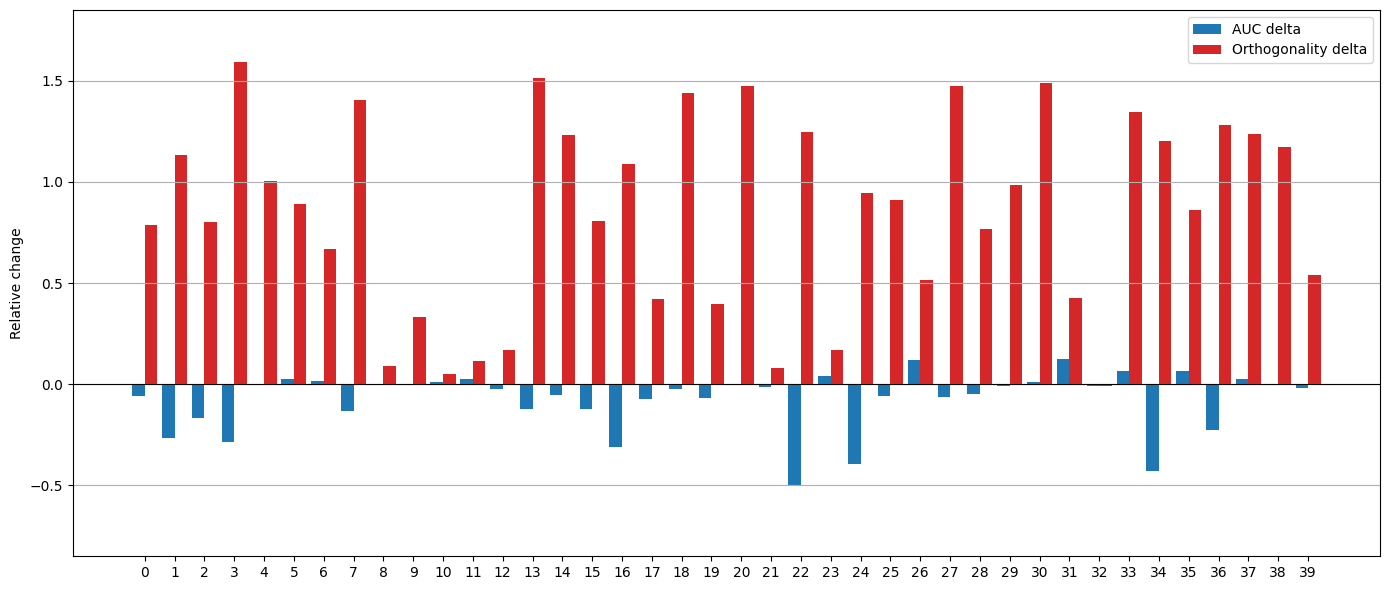

In [22]:
def plot_pattern_to_multi_deltas(
    dataset_name: str,
    model_name: str,
    layer: str,
    *,
    variables_root: Path | str = Path("/home/erogullari/Workspace/cav-disentanglement/variables"),
    concept_names: list[str] | None = None,
    relative: bool = False,
    ylims: tuple[float, float] = (-2, 2),
    eps: float = 1e-12,
    out_path: Path | str | None = None,
):
    vars_path = Path(variables_root) / dataset_name / model_name / f"{layer}.pth"
    vars = torch.load(vars_path, map_location="cpu", weights_only=True)
    encs = vars["encs"]
    labels = vars["labels"].clamp(min=0)

    concept_names = [f"{i}" for i in range(labels.shape[1])]

    cavs_pattern, _ = compute_cavs(encs, labels, type="pattern_cav", normalize=True)
    cavs_multi, _ = compute_cavs(encs, labels, type="multi_cav", normalize=True)

    auc_pattern = compute_auc_performance(cavs_pattern, encs, labels)
    auc_multi = compute_auc_performance(cavs_multi, encs, labels)
    orth_pattern = get_uniqueness(cavs_pattern)
    orth_multi = get_uniqueness(cavs_multi)

    delta_auc = np.array(auc_multi) - np.array(auc_pattern)
    delta_orth = np.array(orth_multi) - np.array(orth_pattern)

    if relative:
        delta_auc = delta_auc / (np.abs(auc_pattern) + eps)
        delta_orth = delta_orth / (np.abs(orth_pattern) + eps)

    x = np.arange(len(concept_names))
    width = 0.42

    fig, ax = plt.subplots(figsize=(max(10, 0.35 * len(concept_names)), 6))
    ax.bar(x - width / 2, delta_auc, width=width, color="tab:blue", label="AUC delta")
    ax.bar(x + width / 2, delta_orth, width=width, color="tab:red", label="Orthogonality delta")

    ax.axhline(0, color="black", linewidth=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(concept_names)
    ax.set_ylabel("Relative change" if relative else "Absolute change")
    # ax.set_title("Pattern → Multi: Per‑Concept Metric Change")
    ax.grid(axis="y")
    ax.legend()

    ax.set_ylim(ylims[0] - 0.1 , ylims[1] + 0.1)

    fig.tight_layout()

    if out_path is not None:
        out_path = Path(out_path)
        fig.savefig(out_path, bbox_inches="tight", format="pdf")

    return {
        "delta_auc": delta_auc,
        "delta_orth": delta_orth,
        "concept_names": concept_names,
    }

ylims = (-0.75, 1.75)
plot_pattern_to_multi_deltas("celeba", "vgg16", "features.28", relative=True,  ylims=ylims, out_path=out_dir / "pattern_to_multi_deltas_celeba.pdf");

Avg AUC Elements: Pattern 0.8411, Multi 0.8274
Avg Orth Elements: Pattern 0.7755, Multi 0.7611


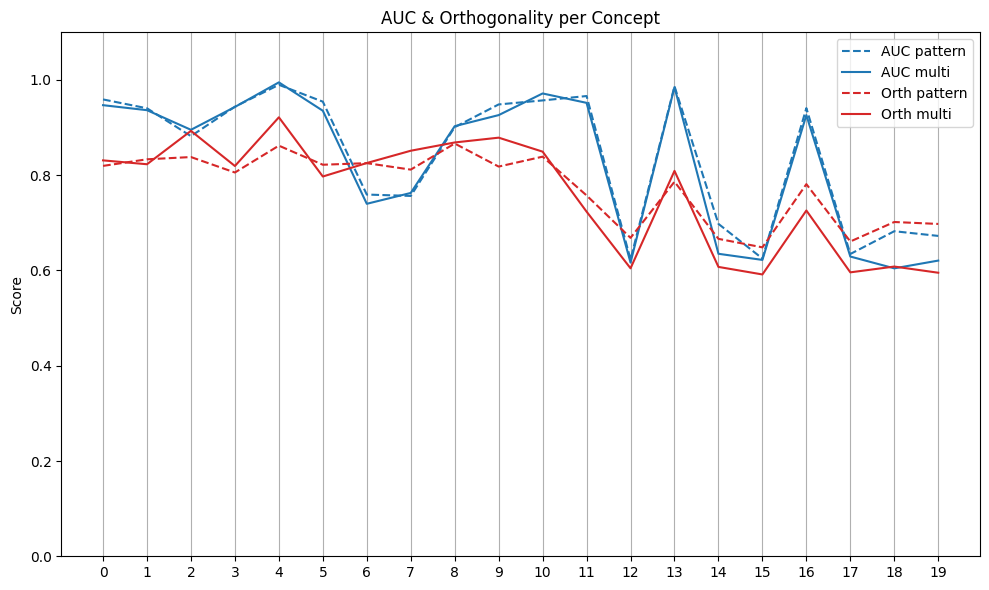

In [7]:
results = plot_pattern_multi_auc_orthogonality("elements", "vgg16", "features.28", out_path=None)
print(f"Avg AUC Elements: Pattern {np.mean(results['auc_pattern']):.4f}, Multi {np.mean(results['auc_multi']):.4f}")
print(f"Avg Orth Elements: Pattern {np.mean(results['orth_pattern']):.4f}, Multi {np.mean(results['orth_multi']):.4f}")

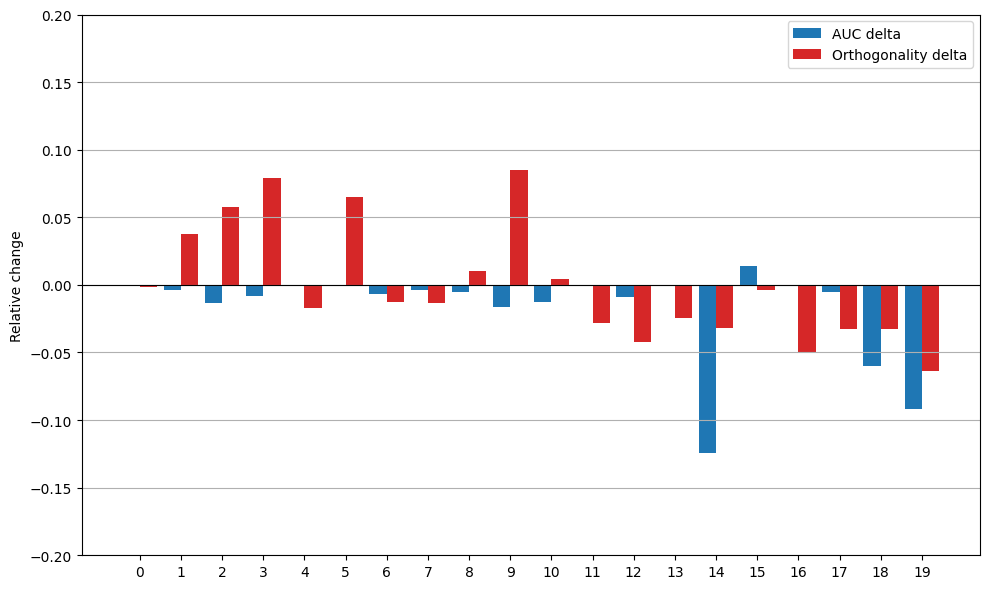

In [25]:
ylims = (-0.1, 0.1)
plot_pattern_to_multi_deltas("elements", "simplenet", "features.18", relative=True,  ylims=ylims, out_path=out_dir / "pattern_to_multi_deltas_elements.pdf");

## Global - CelebA - VGG16 layers

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path

from utils.cav import compute_cavs
from utils.metrics import compute_auc_performance, get_uniqueness


def plot_avg_metric_deltas_over_layers(
    dataset_name: str,
    model_name: str,
    layers: list[str],
    *,
    variables_root: Path | str = Path("/home/erogullari/Workspace/cav-disentanglement/variables"),
    relative: bool = False,
    y_lims: tuple[float, float] | None = None,
    eps: float = 1e-12,
    out_path: Path | str | None = None,
):
    """
    Bar plot of average AUROC/orthogonality change per layer (pattern -> multi).
    If relative=True, uses (multi - pattern) / (abs(pattern) + eps).
    """
    variables_root = Path(variables_root)
    avg_auc_pattern = []
    avg_auc_multi = []
    avg_orth_pattern = []
    avg_orth_multi = []

    for layer in layers:
        vars_path = variables_root / dataset_name / model_name / f"{layer}.pth"
        vars = torch.load(vars_path, map_location="cpu", weights_only=True)
        encs = vars["encs"]
        labels = vars["labels"].clamp(min=0)

        cavs_pattern, _ = compute_cavs(encs, labels, type="pattern_cav", normalize=True)
        cavs_multi, _ = compute_cavs(encs, labels, type="multi_cav", normalize=True)

        auc_pattern = compute_auc_performance(cavs_pattern, encs, labels)
        auc_multi = compute_auc_performance(cavs_multi, encs, labels)
        orth_pattern = get_uniqueness(cavs_pattern)
        orth_multi = get_uniqueness(cavs_multi)

        avg_auc_pattern.append(float(np.nanmean(auc_pattern)))
        avg_auc_multi.append(float(np.nanmean(auc_multi)))
        avg_orth_pattern.append(float(np.nanmean(orth_pattern)))
        avg_orth_multi.append(float(np.nanmean(orth_multi)))

    delta_auc = np.array(avg_auc_multi) - np.array(avg_auc_pattern)
    delta_orth = np.array(avg_orth_multi) - np.array(avg_orth_pattern)

    if relative:
        delta_auc = delta_auc / (np.abs(avg_auc_pattern) + eps)
        delta_orth = delta_orth / (np.abs(avg_orth_pattern) + eps)

    x = np.arange(len(layers))
    width = 0.42

    fig, ax = plt.subplots(figsize=(max(10, 0.5 * len(layers)), 6))
    ax.bar(x - width / 2, delta_auc, width=width, color="tab:blue", label="Avg AUC delta")
    ax.bar(x + width / 2, delta_orth, width=width, color="tab:red", label="Avg Orth delta")

    ax.axhline(0, color="black", linewidth=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels([f"{i}" for i in range(len(layers))])
    ax.set_ylabel("Relative change" if relative else "Absolute change")
    ax.grid(axis="y")
    ax.set_ylim(y_lims[0] - 0.1 , y_lims[1] + 0.1) if y_lims is not None else None

    ax.legend()
    fig.tight_layout()

    if out_path is not None:
        out_path = Path(out_path)
        if out_path.suffix:
            save_path = out_path
        else:
            out_path.mkdir(parents=True, exist_ok=True)
            save_path = out_path / "avg_metric_deltas_over_layers.png"
        fig.savefig(save_path, bbox_inches="tight", format="pdf")

    return {
        "avg_auc_pattern": np.array(avg_auc_pattern),
        "avg_auc_multi": np.array(avg_auc_multi),
        "avg_orth_pattern": np.array(avg_orth_pattern),
        "avg_orth_multi": np.array(avg_orth_multi),
        "delta_auc": delta_auc,
        "delta_orth": delta_orth,
        "layers": layers,
    }



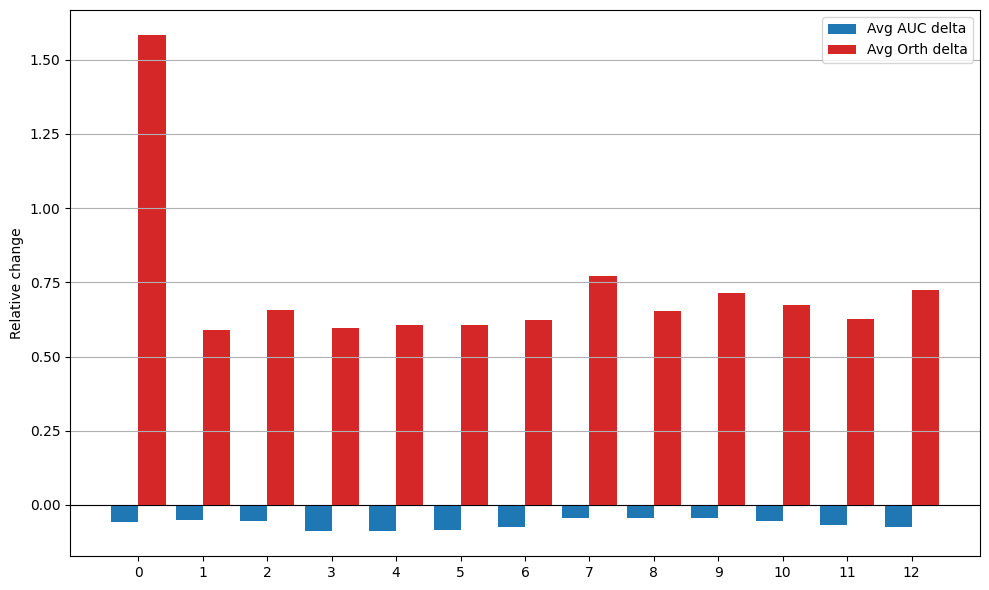

In [14]:
layers = ["features.0", "features.2", "features.5", "features.7", "features.10", "features.12", "features.14", "features.17", "features.19", "features.21", "features.24", "features.26", "features.28"]
plot_avg_metric_deltas_over_layers("celeba", "vgg16", layers, relative=True, out_path=out_dir / "pattern_to_multi_deltas_over_layers_celeba.pdf");

## Concept Localization

In [107]:
import torch
import matplotlib.pyplot as plt
from pathlib import Path

from utils.cav import compute_cavs
from utils.visualizations import visualize_heatmaps
from experiments.utils.localization import get_localization
from models import get_fn_model_loader, get_canonizer


def localize_pattern_multi_cavs(
    image_id: int,
    concept_id: int,
    dataset,
    *,
    dataset_name: str = "celeba",
    model_name: str = "vgg16",
    layer: str = "features.28",
    variables_root: Path | str = Path("/home/erogullari/Workspace/cav-disentanglement/variables"),
    ckpt_path: Path | str | None = None,
    n_class: int | None = None,
    cav_mode: str = "max",
    device: str = "cpu",
    pattern_cavs: torch.Tensor | None = None,
    multi_cavs: torch.Tensor | None = None,
    encs: torch.Tensor | None = None,
    labels: torch.Tensor | None = None,
    out_path: Path | str | None = None,
    dps: bool = False,
):
    # Load encs/labels if not provided (assumes dataset ordering matches cached encs)
    if encs is None or labels is None:
        vars_path = Path(variables_root) / dataset_name / model_name / f"{layer}.pth"
        vars_data = torch.load(vars_path, map_location="cpu", weights_only=True)
        encs = vars_data["encs"]
        labels = vars_data["labels"].clamp(min=0)

    # Compute CAVs if not provided
    if pattern_cavs is None:
        pattern_cavs, _ = compute_cavs(encs, labels, type="pattern_cav", normalize=True)
    if multi_cavs is None:
        multi_cavs, _ = compute_cavs(encs, labels, type="multi_cav", normalize=True)

    # Load model if not provided
    if ckpt_path is None:
        ckpt_path = Path("/media/erogullari/checkpoints") / f"checkpoint_{model_name}_{dataset_name}.pth"

    model = get_fn_model_loader(model_name)(
        ckpt_path=ckpt_path,
        pretrained=True,
        n_class=n_class,
    ).to(device).eval()

    canonizers = get_canonizer(model_name)

    # Get single sample
    sample = dataset[image_id][0].unsqueeze(0)

    # Localize (same logic as localization.py)
    hm_pattern = get_localization(
        pattern_cavs[concept_id].unsqueeze(0),
        sample,
        model,
        canonizers,
        layer,
        cav_mode=cav_mode,
        device=device,
    ).unsqueeze(1)

    hm_multi = get_localization(
        multi_cavs[concept_id].unsqueeze(0),
        sample,
        model,
        canonizers,
        layer,
        cav_mode=cav_mode,
        device=device,
    ).unsqueeze(1)

    heatmaps = torch.cat([hm_pattern, hm_multi], dim=1)[0]

    # Dot products (optional annotation)
    latent = encs[image_id].to(pattern_cavs)
    dp_pattern = torch.dot(latent, pattern_cavs[concept_id].to(latent)).item()
    dp_multi = torch.dot(latent, multi_cavs[concept_id].to(latent)).item()

    concept_names = dataset.get_concept_names()
    concept_name = concept_names[concept_id] if concept_names else f"concept_{concept_id}"

    titles = ["Original Image", "Pattern CAV", "Multi-Pattern CAV"]
    fig = visualize_heatmaps(
        sample[0].detach().cpu(),
        heatmaps,
        conormalize=True,
        suptitle=f"{concept_name} (id={concept_id})",
        titles=titles,
        dot_products=(dp_pattern, dp_multi) if dps else None,
        display=out_path is None,
    )

    if out_path is not None:
        fig.savefig(out_path, bbox_inches="tight", format="pdf")
    return fig

save_dir = out_dir / "localizations"
save_dir.mkdir(parents=True, exist_ok=True)

In [36]:
pattern_cavs = get_baseline_cavs("vgg16", "features.28", "celeba", "pattern_cav")
multi_cavs = get_baseline_cavs("vgg16", "features.28", "celeba", "multi_cav")

In [16]:
from datasets.celeba.celeba import CelebADataset
from hydra.utils import instantiate
from omegaconf import OmegaConf

cfg = OmegaConf.load("/home/erogullari/Workspace/cav-disentanglement/configs/dataset/celeba.yaml")
dataset = instantiate(cfg)
len(dataset)

202599

In [20]:
concept_names = dataset.get_concept_names()
for i in range(len(concept_names)):
    print(f"{i}: {concept_names[i]}")

0: 5_o_Clock_Shadow
1: Arched_Eyebrows
2: Attractive
3: Bags_Under_Eyes
4: Bald
5: Bangs
6: Big_Lips
7: Big_Nose
8: Black_Hair
9: Blond_Hair
10: Blurry
11: Brown_Hair
12: Bushy_Eyebrows
13: Chubby
14: Double_Chin
15: Eyeglasses
16: Goatee
17: Gray_Hair
18: Heavy_Makeup
19: High_Cheekbones
20: Male
21: Mouth_Slightly_Open
22: Mustache
23: Narrow_Eyes
24: No_Beard
25: Oval_Face
26: Pale_Skin
27: Pointy_Nose
28: Receding_Hairline
29: Rosy_Cheeks
30: Sideburns
31: Smiling
32: Straight_Hair
33: Wavy_Hair
34: Wearing_Earrings
35: Wearing_Hat
36: Wearing_Lipstick
37: Wearing_Necklace
38: Wearing_Necktie
39: Young


In [112]:
concept_idx = 35
print(f"Selected concept: {concept_names[concept_idx]}")

indices = np.where(dataset.get_labels()[:, concept_idx] == 1)[0]
print(f"Number of samples with concept: {len(indices)}")

Selected concept: Wearing_Hat
Number of samples with concept: 9818


In [114]:
# Example:
start = 0
for pos in range(start, start + 20):
    path = save_dir / f"concept_{concept_names[concept_idx]}_img_{indices[pos]}.pdf"
    localize_pattern_multi_cavs(
        image_id=indices[pos],
        concept_id=concept_idx,
        dataset=dataset,
        n_class=2,
        out_path=path,
        pattern_cavs=pattern_cavs,
        multi_cavs=multi_cavs,
        dps=False 
    );


## Concept Co-Localization

In [116]:
import torch
import matplotlib.pyplot as plt
from pathlib import Path

from utils.cav import compute_cavs
from utils.visualizations import visualize_heatmap_pair
from experiments.utils.localization import get_localization
from models import get_fn_model_loader, get_canonizer


def colocalize_pattern_multi_cavs(
    image_id: int,
    concept_id_1: int,
    concept_id_2: int,
    dataset,
    *,
    dataset_name: str = "celeba",
    model_name: str = "vgg16",
    layer: str = "features.28",
    variables_root: Path | str = Path("/home/erogullari/Workspace/cav-disentanglement/variables"),
    ckpt_path: Path | str | None = None,
    n_class: int | None = None,
    dps: bool = False,
    cav_mode: str = "max",
    device: str = "cpu",
    pattern_cavs: torch.Tensor | None = None,
    multi_cavs: torch.Tensor | None = None,
    encs: torch.Tensor | None = None,
    labels: torch.Tensor | None = None,
    out_path: Path | str | None = None,
):
    # Load encs/labels if not provided (assumes dataset ordering matches cached encs)
    if encs is None or labels is None:
        vars_path = Path(variables_root) / dataset_name / model_name / f"{layer}.pth"
        vars_data = torch.load(vars_path, map_location="cpu", weights_only=True)
        encs = vars_data["encs"]
        labels = vars_data["labels"].clamp(min=0)

    # Compute CAVs if not provided
    if pattern_cavs is None:
        pattern_cavs, _ = compute_cavs(encs, labels, type="pattern_cav", normalize=True)
    if multi_cavs is None:
        multi_cavs, _ = compute_cavs(encs, labels, type="multi_cav", normalize=True)

    # Load model if not provided
    if ckpt_path is None:
        ckpt_path = Path("/media/erogullari/checkpoints") / f"checkpoint_{model_name}_{dataset_name}.pth"

    model = get_fn_model_loader(model_name)(
        ckpt_path=ckpt_path,
        pretrained=True,
        n_class=n_class,
    ).to(device).eval()

    canonizers = get_canonizer(model_name)

    # Get single sample
    sample = dataset[image_id][0].unsqueeze(0)

    # Heatmaps for pattern CAVs
    hm_pat_c1 = get_localization(
        pattern_cavs[concept_id_1].unsqueeze(0),
        sample,
        model,
        canonizers,
        layer,
        cav_mode=cav_mode,
        device=device,
    ).unsqueeze(1)

    hm_pat_c2 = get_localization(
        pattern_cavs[concept_id_2].unsqueeze(0),
        sample,
        model,
        canonizers,
        layer,
        cav_mode=cav_mode,
        device=device,
    ).unsqueeze(1)

    # Heatmaps for multi CAVs
    hm_mul_c1 = get_localization(
        multi_cavs[concept_id_1].unsqueeze(0),
        sample,
        model,
        canonizers,
        layer,
        cav_mode=cav_mode,
        device=device,
    ).unsqueeze(1)

    hm_mul_c2 = get_localization(
        multi_cavs[concept_id_2].unsqueeze(0),
        sample,
        model,
        canonizers,
        layer,
        cav_mode=cav_mode,
        device=device,
    ).unsqueeze(1)

    heatmaps_pattern = torch.cat([hm_pat_c1, hm_pat_c2], dim=1)[0]
    heatmaps_multi = torch.cat([hm_mul_c1, hm_mul_c2], dim=1)[0]
    pair_heatmaps = torch.stack([heatmaps_pattern, heatmaps_multi])  # (2, 2, H, W)

    # Dot products (optional annotations)
    latent = encs[image_id].to(pattern_cavs)
    dp_pattern = torch.matmul(latent, pattern_cavs[[concept_id_1, concept_id_2]].to(latent).T)
    dp_multi = torch.matmul(latent, multi_cavs[[concept_id_1, concept_id_2]].to(latent).T)
    dot_products = torch.stack([dp_pattern, dp_multi], dim=0)

    concept_names = dataset.get_concept_names()
    name_1 = concept_names[concept_id_1] if concept_names else f"concept_{concept_id_1}"
    name_2 = concept_names[concept_id_2] if concept_names else f"concept_{concept_id_2}"

    fig = visualize_heatmap_pair(
        sample[0].detach().cpu(),
        pair_heatmaps.detach().cpu(),
        titles=["Original Image", name_1, name_2],
        row_titles=["Pattern CAV", "Multi CAV"],
        dot_products=dot_products.detach().cpu() if dps else None,
        conormalize=True,  # conormalize all 4 heatmaps together
        display=out_path is None,
    )

    if out_path is not None:
        fig.savefig(out_path, bbox_inches="tight", format="pdf")
    return fig

save_dir = out_dir / "colocalizations"
save_dir.mkdir(parents=True, exist_ok=True)

In [92]:
pattern_cavs = get_baseline_cavs("vgg16", "features.28", "celeba", "pattern_cav")
multi_cavs = get_baseline_cavs("vgg16", "features.28", "celeba", "multi_cav")

In [93]:
from datasets.celeba.celeba import CelebADataset
from hydra.utils import instantiate
from omegaconf import OmegaConf

cfg = OmegaConf.load("/home/erogullari/Workspace/cav-disentanglement/configs/dataset/celeba.yaml")
dataset = instantiate(cfg)
len(dataset)

202599

In [94]:
concept_names = dataset.get_concept_names()
for i in range(len(concept_names)):
    print(f"{i}: {concept_names[i]}")

0: 5_o_Clock_Shadow
1: Arched_Eyebrows
2: Attractive
3: Bags_Under_Eyes
4: Bald
5: Bangs
6: Big_Lips
7: Big_Nose
8: Black_Hair
9: Blond_Hair
10: Blurry
11: Brown_Hair
12: Bushy_Eyebrows
13: Chubby
14: Double_Chin
15: Eyeglasses
16: Goatee
17: Gray_Hair
18: Heavy_Makeup
19: High_Cheekbones
20: Male
21: Mouth_Slightly_Open
22: Mustache
23: Narrow_Eyes
24: No_Beard
25: Oval_Face
26: Pale_Skin
27: Pointy_Nose
28: Receding_Hairline
29: Rosy_Cheeks
30: Sideburns
31: Smiling
32: Straight_Hair
33: Wavy_Hair
34: Wearing_Earrings
35: Wearing_Hat
36: Wearing_Lipstick
37: Wearing_Necklace
38: Wearing_Necktie
39: Young


In [129]:
concept_idx1 = 9
concept_idx2 = 24
print(f"Selected concepts: {concept_names[concept_idx1]} and {concept_names[concept_idx2]}")

indices = np.where((dataset.get_labels()[:, concept_idx1] == 1) & (dataset.get_labels()[:, concept_idx2] == 1))[0]
print(f"Number of samples with concept: {len(indices)}")

Selected concepts: Blond_Hair and No_Beard
Number of samples with concept: 29592


In [130]:
# Example:
start = 0
for pos in range(start, start + 20):
    path = save_dir / f"concept_{concept_names[concept_idx1]}_{concept_names[concept_idx2]}_img_{indices[pos]}.pdf"
    colocalize_pattern_multi_cavs(
        image_id=indices[pos],
        concept_id_1=concept_idx1,
        concept_id_2=concept_idx2,
        dataset=dataset,
        n_class=2,
        out_path=path,
        pattern_cavs=pattern_cavs,
        multi_cavs=multi_cavs,
        dps=False
    )
